## Tracking de Icebergs

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
import h5py

In [9]:
import ee
import folium
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


- Primero definimos nuestro icebergs de interes

Para este proceso, directamente en Google engine seleccionamos manualmente el icebreg de interes. Usando el siguiente codigo.

In [ ]:
# var roi = ee.Geometry.Polygon([
#   [[-112, -72.7], [-112, -73.7], [-108.5, -73.7], [-108.5, -72.7], [-112, -72.7]]
# ]);

# var startdate = '2017-04-19' 
# var enddate = '2017-04-20' 

# var S1 = sentinel1
#   // Filter to get images with VV and VH dual polarization.
#   //.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
#   // Filter to get images collected in interferometric wide swath mode.
#   .filterDate(startdate, enddate) 
#   // .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
#   .filterBounds(roi);
  
# print(S1)
# var img = S1.select("HH")

# var visParams1 = {band: ['HH'], min: -30, max: 0};
# // var visParams2 = {band: ['B4'], max: 10000, min: 0};

# Map.addLayer(img, visParams1, 'S1');

# Definimos "geometry" manualmente
# var geometry = ee.FeatureCollection(geometry)
# Export.table.toDrive(geometry, 'iceberg_' + startdate, 'users/kooala317/Iceberg_tracking')

In [2]:
from shapely.geometry import shape
import json

In [3]:
df = pd.read_csv("Icebergs\iceberg_0000_2020-04-19.csv")
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs('epsg:4326', inplace=True)

In [7]:
gdf

,system:index,.geo,geometry
0,0,"{""type"":""Polygon"",""coordinates"":[[[-107.204257...","POLYGON ((-107.20426 -74.24049, -107.22211 -74..."


<Axes: >

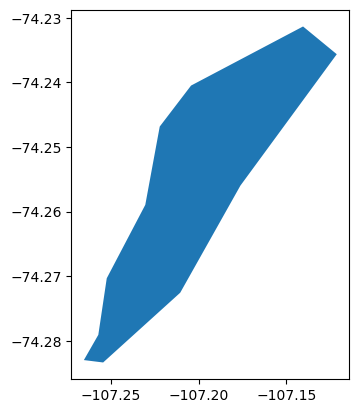

In [4]:
gdf["geometry"].plot()

- Luego, haciendo comparativas de similitud, localizamos el mismo iceberg en una imagen posterior. (Con un cierto margen de error)

#### 1. Pasamos nuestro archivo local a una Feature collection

In [11]:
from shapely.geometry import shape, mapping

In [27]:
gdf.columns = [col.replace('.', '_') for col in gdf.columns]

# Verificamos que todas las columnas son strings
for col in gdf.columns:
    if col != 'geometry':
        gdf[col] = gdf[col].astype(str)

# Convertimos el GeoDataFrame a una lista de Features
features = []
for _, row in gdf.iterrows():
    geom = ee.Geometry(mapping(row['geometry']))
    feature = ee.Feature(geom, row.drop('geometry').to_dict())
    features.append(feature)


iceberg = ee.FeatureCollection(features)


#### 2. Una vez obtenida la feature collection del iceberg, obtenemos las imagenes satelitales de esté.  Junto con el centroide del iceberg.

In [58]:
fecha_inicio = '2020-04-19'
fecha_fin = '2020-04-20'

In [71]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(iceberg)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean().clip(iceberg) 

centroid = iceberg.geometry().centroid(10).getInfo()['coordinates']

#### 3. Planteamos una forma de identificar el iceberg. Esta forma requiere calcular cómo varía la distancia desde el centroide hacia los bordes del iceberg. Para ello:

- Definimos una capa de cobertura del iceberg, la cual vale 1 siempre que se abarca el iceberg.

In [72]:
cover = img.select('HH').clip(iceberg).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())

- Definimos una Imagen que vale 1 en el centroide del Iceberg.

In [73]:
sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)

- Calculamos el costo acumulativo para recorrer la imagen desde el centroide del iceberg hasta los bordes del iceberg.

In [74]:
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(iceberg)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), iceberg, scale=200, maxPixels=1e20)
A = result.getInfo()['cumulative_cost'] 

- Calculamos un histograma de la distribucion de las distancias centroide-borde

Text(0, 0.5, 'N')

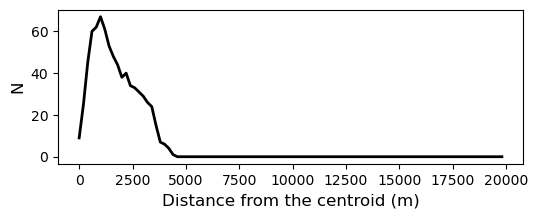

In [75]:
hist1 = {}

scale = 200
max_pix = 20000

fig = plt.subplots(figsize = (6, 2), dpi = 100)
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])

plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

- Obtenemos el area real del iceberg

In [57]:
area0 = iceberg.geometry().area(10).getInfo()
print(area0)

8256820.092200294
